# Loading libraries

In [27]:
import sympy
from sympy import symbols, diff, lambdify, Symbol
import numpy as np
import torch
from torch.autograd.functional import hessian
torch.set_printoptions(3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import cycle
# lines = ["-","--","-.",":"]
lines = ["--", "-."]
linecycler = cycle(lines)
import pickle
import os
import time

# Load iris data set

In [2]:
iris = load_iris()
x = iris['data']
y = iris['target']
x = x[np.where(y!=0)[0]]
y = 2 * (y[np.where(y!=0)[0]] - 1) - 1
names = iris['target_names']
names = names[1:]
feature_names = iris['feature_names']
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = torch.tensor(x, device=device, dtype=float)
y = torch.tensor(y, device=device, dtype=float)

# Defining symbolic neural network and finding the polynomials of the ODE

In [3]:
'''MLP with 1 hidden layer with 10 parameters'''
hidden = 10
# Total parameters are from w1 (4 x hidden), h1 (hidden) and w2 (hidden x 1). Total 6 * hidden
n_params = 6 * hidden
symbol_string = ''
for i in range(n_params):
    symbol_string += 'p{} '.format(i)
symbol_list = symbols(symbol_string)
params = np.array(symbol_list)
sym_x = [Symbol("x0"), Symbol("x1"), Symbol("x2"), Symbol("x3")]
sym_y = Symbol("y")

'''Finding the terms and coefficients of the ODE polynomial'''
# Load file directly if saved pickle file exists
if os.path.exists("terms_{}.pickle".format(hidden)):
    with open("terms_{}.pickle".format(hidden), "rb") as input_file:
        terms = pickle.load(input_file)
    # This is the order of the ODE, which is the highest order of the polynomial stored in 'derivatives'. This may be larger for larger networks
    q = 5
# Otherwise create a symbolic neural network, differentiate it, and record the coefficients
else:
    '''Defining the neural network symbolically'''
    # Neural network definition
    def net(x, params, hidden):
        w1_end = 4*hidden
        b1_end = w1_end + hidden
        w2_end = b1_end + hidden
        assert w2_end == params.shape[0]
        w1 = params[:w1_end].reshape(hidden, 4)
        b1 = params[w1_end:b1_end]
        w2 = params[b1_end:w2_end]
        x = np.tensordot(x, w1, axes=([0],[1]))
        x = x + b1
        x = x**2
        x = np.dot(x, w2)
        return x
    # Loss definition
    def net_loss(x, y, params, hidden):
        return (net(x, params, hidden) - y)**2

    '''Symbolic derivatives of Loss w.r.t. to neural net parameters'''
    # The list 'derivatives' hold all the symbolic derivatives of neural net parameters w.r.t. other parameters. Data x, y symbols are treated as constants
    derivatives = []
    for i in range(n_params):
        derivative = diff(net_loss(sym_x, sym_y, params, hidden), symbol_list[i])
        derivatives.append(derivative)

    # This is the order of the ODE, which is the highest order of the polynomial stored in 'derivatives'. This may be larger for larger networks
    q = 5
    # Store the terms and coefficients as a list of lists. 
    # Each list contains terms for the derivative w.r.t. a given parameter, which are separated into lists of terms of 0 through q orders.
    # Each term is a tuple of parameter exponents (p0**2 * p3**3 * p5 is given by (2, 0, 0, 3, 0, 1, 0, 0, ...)) and the coefficient.
    terms = [[[] for _ in range(0, q + 1)] for _ in range(n_params)]
    for parameter in range(n_params):
        # The sympy.Poly class can enumerate all terms of an expression by the method self.terms().
        # We express the derivative w.r.t. each parameter as a polynomial in terms of the neural network parameters.
        # Coefficients are given in terms of training data x, y.
        for term in sympy.Poly(derivatives[parameter], symbol_list).terms():
            # Symbolic expression of the coefficient of the term
            expr = term[1]
            # Convert the sympy expression into a function that can be evaluated numerically using numpy backend (torch is support by 'numpy')
            expr_function = lambdify([sym_x, sym_y], expr, 'numpy')
            # For expressions that involve x and y, torch.mean evaluates successfully.
            try:
                coefficient = torch.mean(expr_function((x[:,0],x[:,1],x[:,2],x[:,3]), y)).item()
            # If the expression is a number that doesn't involve x, y, expr_function returns a number and cannot be evaluated by torch.mean, simply turn expr into float
            except TypeError:
                print(expr)
                coefficient = float(expr)
            # Append the term as a tuple of parameter exponents (term[0]) and the numerical coefficient
            terms[parameter][np.sum(term[0])].append((term[0], coefficient))
    # Save the computed terms
    with open("terms_{}.pickle".format(hidden), "wb") as output_file:
        pickle.dump(terms, output_file)


# Numerical schemes for simulating the linearized solver

In [4]:
'''Defining the neural network that will be evaluated numerically'''
def numerical_net(x, params, hidden):
    w1_end = 4*hidden
    b1_end = w1_end + hidden
    w2_end = b1_end + hidden
    assert w2_end == params.shape[0]
    w1 = params[:w1_end].reshape(hidden, 4)
    b1 = params[w1_end:b1_end]
    w2 = params[b1_end:w2_end]
    x = torch.tensordot(x, w1, dims=([1],[1]))
    x = x + b1
    x = x**2
    x = torch.tensordot(x, w2, dims=[[1],[0]])
    return x

def numerical_loss(x, y, params, hidden):
    y_hat = numerical_net(x, params, hidden)
    loss = torch.mean((y - y_hat)**2)
    return loss

# Loss as a function of only the neural network parameters. This form is necessary for calculating the Hessian
def loss_with_data(params):
    return numerical_loss(x, y, params, hidden)

def update(values, q, terms, learning_rate):
    """update function for simulating the linearized approaching to solve the ODE.
        
        Parameters
        ----------
        values : torch.Tensor
            The y_hat vector in a simplified form. 0th dimension for order from 0 to N. 1st dimension for different parameters.
        q: int
            Order of the ODE.
        terms: List
            Store the terms and coefficients as a list of lists. 
            Each list contains terms for the derivative w.r.t. a given parameter, which are separated into lists of terms of 0 through q orders.
            Each term is a tuple of parameter exponents (p0**2 * p3**3 * p5 is given by (2, 0, 0, 3, 0, 1, 0, 0, ...)) and the coefficient.
        learning_rate: float
            The learning rate.
        """
    total_orders, parameters = values.shape
    # Buffer storing the delta y_hat, the change to values.
    addition = torch.zeros_like(values).to(device)
    # Calculate changes to y_hat due to the order-th order dynamics
    for order in range(0, q + 1):
        # We compute the change to all orders of y_hat at once.
        # For order-th order dynamics, changes of i-th order terms are due to values from (i+order)th order terms, which we sotre as order_values.
        if order != 0:
            # Sources of change
            order_values = torch.concat([torch.clone(values[order-1:]), torch.zeros([order-1, parameters]).to(device)])
            order_values[-q:] = 0
        for parameter in range(parameters):
            for term in terms[parameter][order]:
                # Changes due to the term. Initialized to the coefficient of the term.
                term_values = torch.ones(total_orders).to(device) * float(term[1])
                for i, power in enumerate(term[0]):
                    if power != 0:
                        term_values *= order_values[:, i]**power
                addition[:, parameter] -= learning_rate * term_values    
    values += addition

# Perfect ODE update
def ideal_update(values, learning_rate):
    loss = loss_with_data(values)
    loss.backward()
    with torch.no_grad():
        values -= learning_rate * values.grad
        values.grad.zero_()

# Numerical simulation

Change the boolean value `reproduce` to False if want to train with new initial parameters instead of reproducing the results in the paper. Change the boolean value `resimulate` to True if want to rerun the simulation instead of using the loaded simulation results.

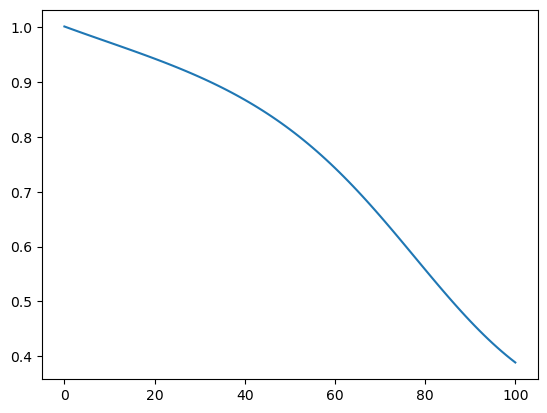

In [5]:
'''Numerical neural network parameters'''
numerical_w1 = (2*np.random.rand(4*hidden)-1)/np.sqrt(4)
numerical_h1 = np.zeros(hidden)
numerical_w2 = (2*np.random.rand(hidden)-1)/np.sqrt(hidden)

'''Training parameters'''
epochs = 100
learning_rate = 0.01

'''Ideal evolution according to the true difference equation'''
values_start = np.concatenate([numerical_w1, numerical_h1, numerical_w2]).reshape(1, -1)
reproduce = True
if reproduce:
    with open('approx_trajectory.pickle', 'rb') as file:
        approx_trajectory = pickle.load(file)
    values_start = approx_trajectory[0][0].reshape(1,-1)
ideal_values = torch.tensor(values_start[0], requires_grad = True, device=device)
ideal_trajectory = [np.copy(ideal_values.cpu().detach().numpy())]
ideal_loss = loss_with_data(ideal_values)
ideal_losses = [ideal_loss.item()]
evals = torch.empty([0, n_params])
evals = torch.concat([evals, torch.sort(torch.real(torch.linalg.eigvals(hessian(loss_with_data, ideal_values)))).values.reshape(1,-1).cpu().detach()])
for epoch in range(epochs):
    ideal_update(ideal_values, learning_rate)
    loss = loss_with_data(ideal_values)
    evals = torch.concat([evals, torch.sort(torch.real(torch.linalg.eigvals(hessian(loss_with_data, ideal_values)))).values.reshape(1,-1).cpu().detach()])
    ideal_loss = loss_with_data(ideal_values)
    ideal_losses.append(ideal_loss.item())
    ideal_trajectory.append(np.copy(ideal_values.cpu().detach().numpy()))

plt.plot(ideal_losses)
plt.show()

'''Simulation of the linearized solver'''
# Maximum order of QDM for the linearized solver
total_orders = 30
resimulate = False
if resimulate and not reproduce:
    # Stores the trajectory of the linearized solver
    approx_trajectory = [[] for _ in range(q, total_orders + 1, q)]

    for i, orders in enumerate(range(q, total_orders + 1, q)):
        start = time.time()
        # # y_hat for linearized solver
        values = np.repeat(np.copy(values_start), orders + 1, axis=0)
        values = torch.tensor(values).to(device)
        approx_trajectory[i] = [np.copy(values[0].cpu().detach().numpy())]
        loss = loss_with_data(values[0])
        print(loss.item())
        for epoch in range(epochs):
            update(values, 5, terms, learning_rate)
            loss = loss_with_data(values[0])
            # break the training loop if the linearized solver becomes numerically unstable
            if loss > 1.5 or torch.max(values[0]).item() > 10 or torch.isnan(values[0]).sum().item() != 0:
                print('break at epoch {} with loss {}, max parameter {} and {} nan elements.'.format(epoch, loss.item(), torch.max(values[0]).item(), torch.isnan(values[0]).sum().item()))
                break
            print(loss.item())
            approx_trajectory[i].append(np.copy(values[0].cpu().detach().numpy()))
        print('Time taken for order {}: {} seconds.'.format(orders, time.time() - start))

'''Compute and store losses'''
losses = [[] for _ in range(q, total_orders + 1, q)]
for i, orders in enumerate(range(q, total_orders + 1, q)):
    for epoch in range(len(approx_trajectory[i])):
        loss = loss_with_data(torch.tensor(approx_trajectory[i][epoch], device=device))
        losses[i].append(loss.item())

### Uncomment and run cell to load the results used in the manuscript to reproduce figures

In [6]:
# with open('approx_trajectory.pickle', 'rb') as file:
#     approx_trajectory = pickle.load(file)

### Uncomment and run cell to save the simulated trajectories

In [7]:
# with open('approx_trajectory.pickle', 'wb') as file:
#     pickle.dump(approx_trajectory, file)

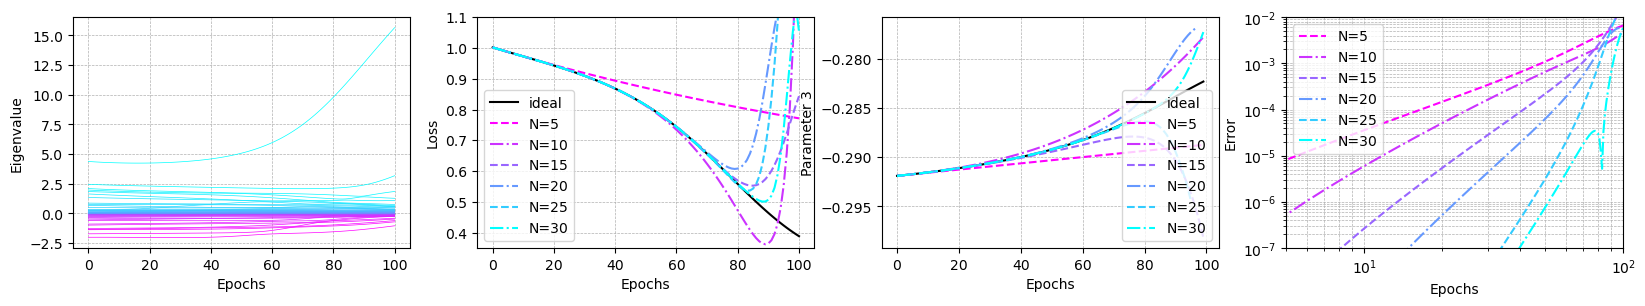

In [30]:
max_length = 100
f = plt.figure(figsize=(20,3))
ax1 = f.add_subplot(141)
ax2 = f.add_subplot(142)
ax3 = f.add_subplot(143)
ax4 = f.add_subplot(144)


colors = cm.cool(np.linspace(1, 0, n_params))
for i in range(n_params):
    ax1.plot(evals[:, i], color=colors[i], linewidth = 0.5)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Eigenvalue')
ax1.grid(which='both', linestyle = '--', linewidth = 0.5)
# Uncomment for better resolution of near 0 eigenvalues
# ax1.set_yscale('symlog', linthresh=0.1)


colors = cm.cool(np.linspace(1, 0, total_orders // q))
ax2.plot(ideal_losses, label='ideal', color='black')
for i, orders in enumerate(range(q, total_orders + 1, q)):
    length = min(max_length, len(approx_trajectory[i]))
    ax2.plot(losses[i], next(linecycler), label='N={}'.format(orders), color=colors[i])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_ylim(0.35,1.1)
ax2.grid(which='both', linestyle = '--', linewidth = 0.5)
ax2.legend()


parameter = 2
colors = cm.cool(np.linspace(1, 0, total_orders // q))
ax3.plot(np.array(ideal_trajectory)[:max_length, parameter], label='ideal', color='black')
for i, orders in enumerate(range(q, total_orders + 1, q)):
    length = min(max_length, len(approx_trajectory[i]))
    ax3.plot(np.array(approx_trajectory[i])[:length, parameter], next(linecycler), label='N={}'.format(orders), color=colors[i])
ax3.legend()
ax3.grid(which='both', linestyle = '--', linewidth = 0.5)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Parameter {}'.format(parameter + 1))

colors = cm.cool(np.linspace(1, 0, total_orders // q))
for i, orders in enumerate(range(q, total_orders + 1, q)):
    length = len(approx_trajectory[i])
    ax4.plot(np.abs(np.array(approx_trajectory[i])[ : length, parameter] - np.array(ideal_trajectory)[ : length, parameter]), next(linecycler), label='N={}'.format(orders), color=colors[i])
ax4.legend()
ax4.grid(which='both', linestyle = '--', linewidth = 0.5)
ax4.set_yscale('log')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Error')
ax4.set_xlim(5,100)
ax4.set_ylim(10**(-7), 10**(-2))
ax4.set_xscale('log')


plt.savefig('Heissian eigenvalues and loss.svg')
plt.show()

Text(0.5, 0, 'step')

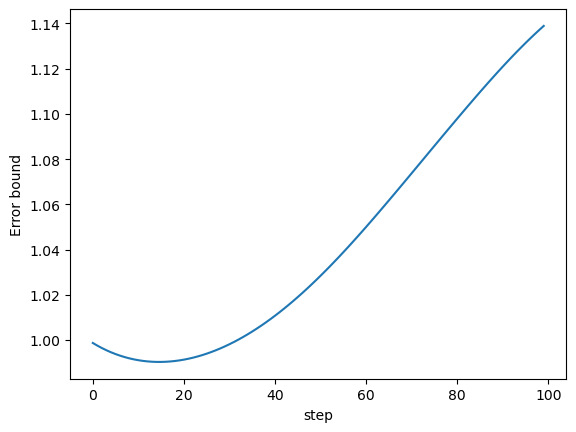

In [10]:
val = torch.ones(n_params)
vals = []
for step in range(100):
    eigval = (1 - learning_rate * evals[step])
    val *= eigval
    vals.append(np.copy(val))

plt.plot(np.mean(np.array(vals), axis=1))
# plt.ylim(0, 4)
# plt.xlim(0, 5)
plt.ylabel('Error bound')
plt.xlabel('step')